In [9]:
# COMMENTED OUT - Run env_prep.sh to set environment
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# !pip install layoutparser # Install the base layoutparser library with  
# !pip install "layoutparser[layoutmodels]" # Install DL layout model toolkit 
# !pip install "layoutparser[ocr]" # Install OCR toolkit
# !pip install "opencv-python-headless<4.3" # https://github.com/opencv/opencv-python/issues/591
# !apt update && apt upgrade -y && apt install -y poppler-utils

In [2]:
# !git clone https://github.com/Layout-Parser/layout-model-training.git

In [10]:
from pycocotools.coco import COCO
import layoutparser as lp
import random
import cv2

def load_coco_annotations(annotations, coco=None):
    """
    Args:
        annotations (List):
            a list of coco annotaions for the current image
        coco (`optional`, defaults to `False`):
            COCO annotation object instance. If set, this function will
            convert the loaded annotation category ids to category names
            set in COCO.categories
    """
    layout = lp.Layout()

    for ele in annotations:

        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type  = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )

    return layout

In [11]:
COCO_ANNO_PATH = './data/annotations/result.json'
COCO_IMG_PATH  = './data/annotations/'

coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/tmp/ipykernel_2134/2968026982.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for image_id in random.sample(coco.imgs.keys(), 2):


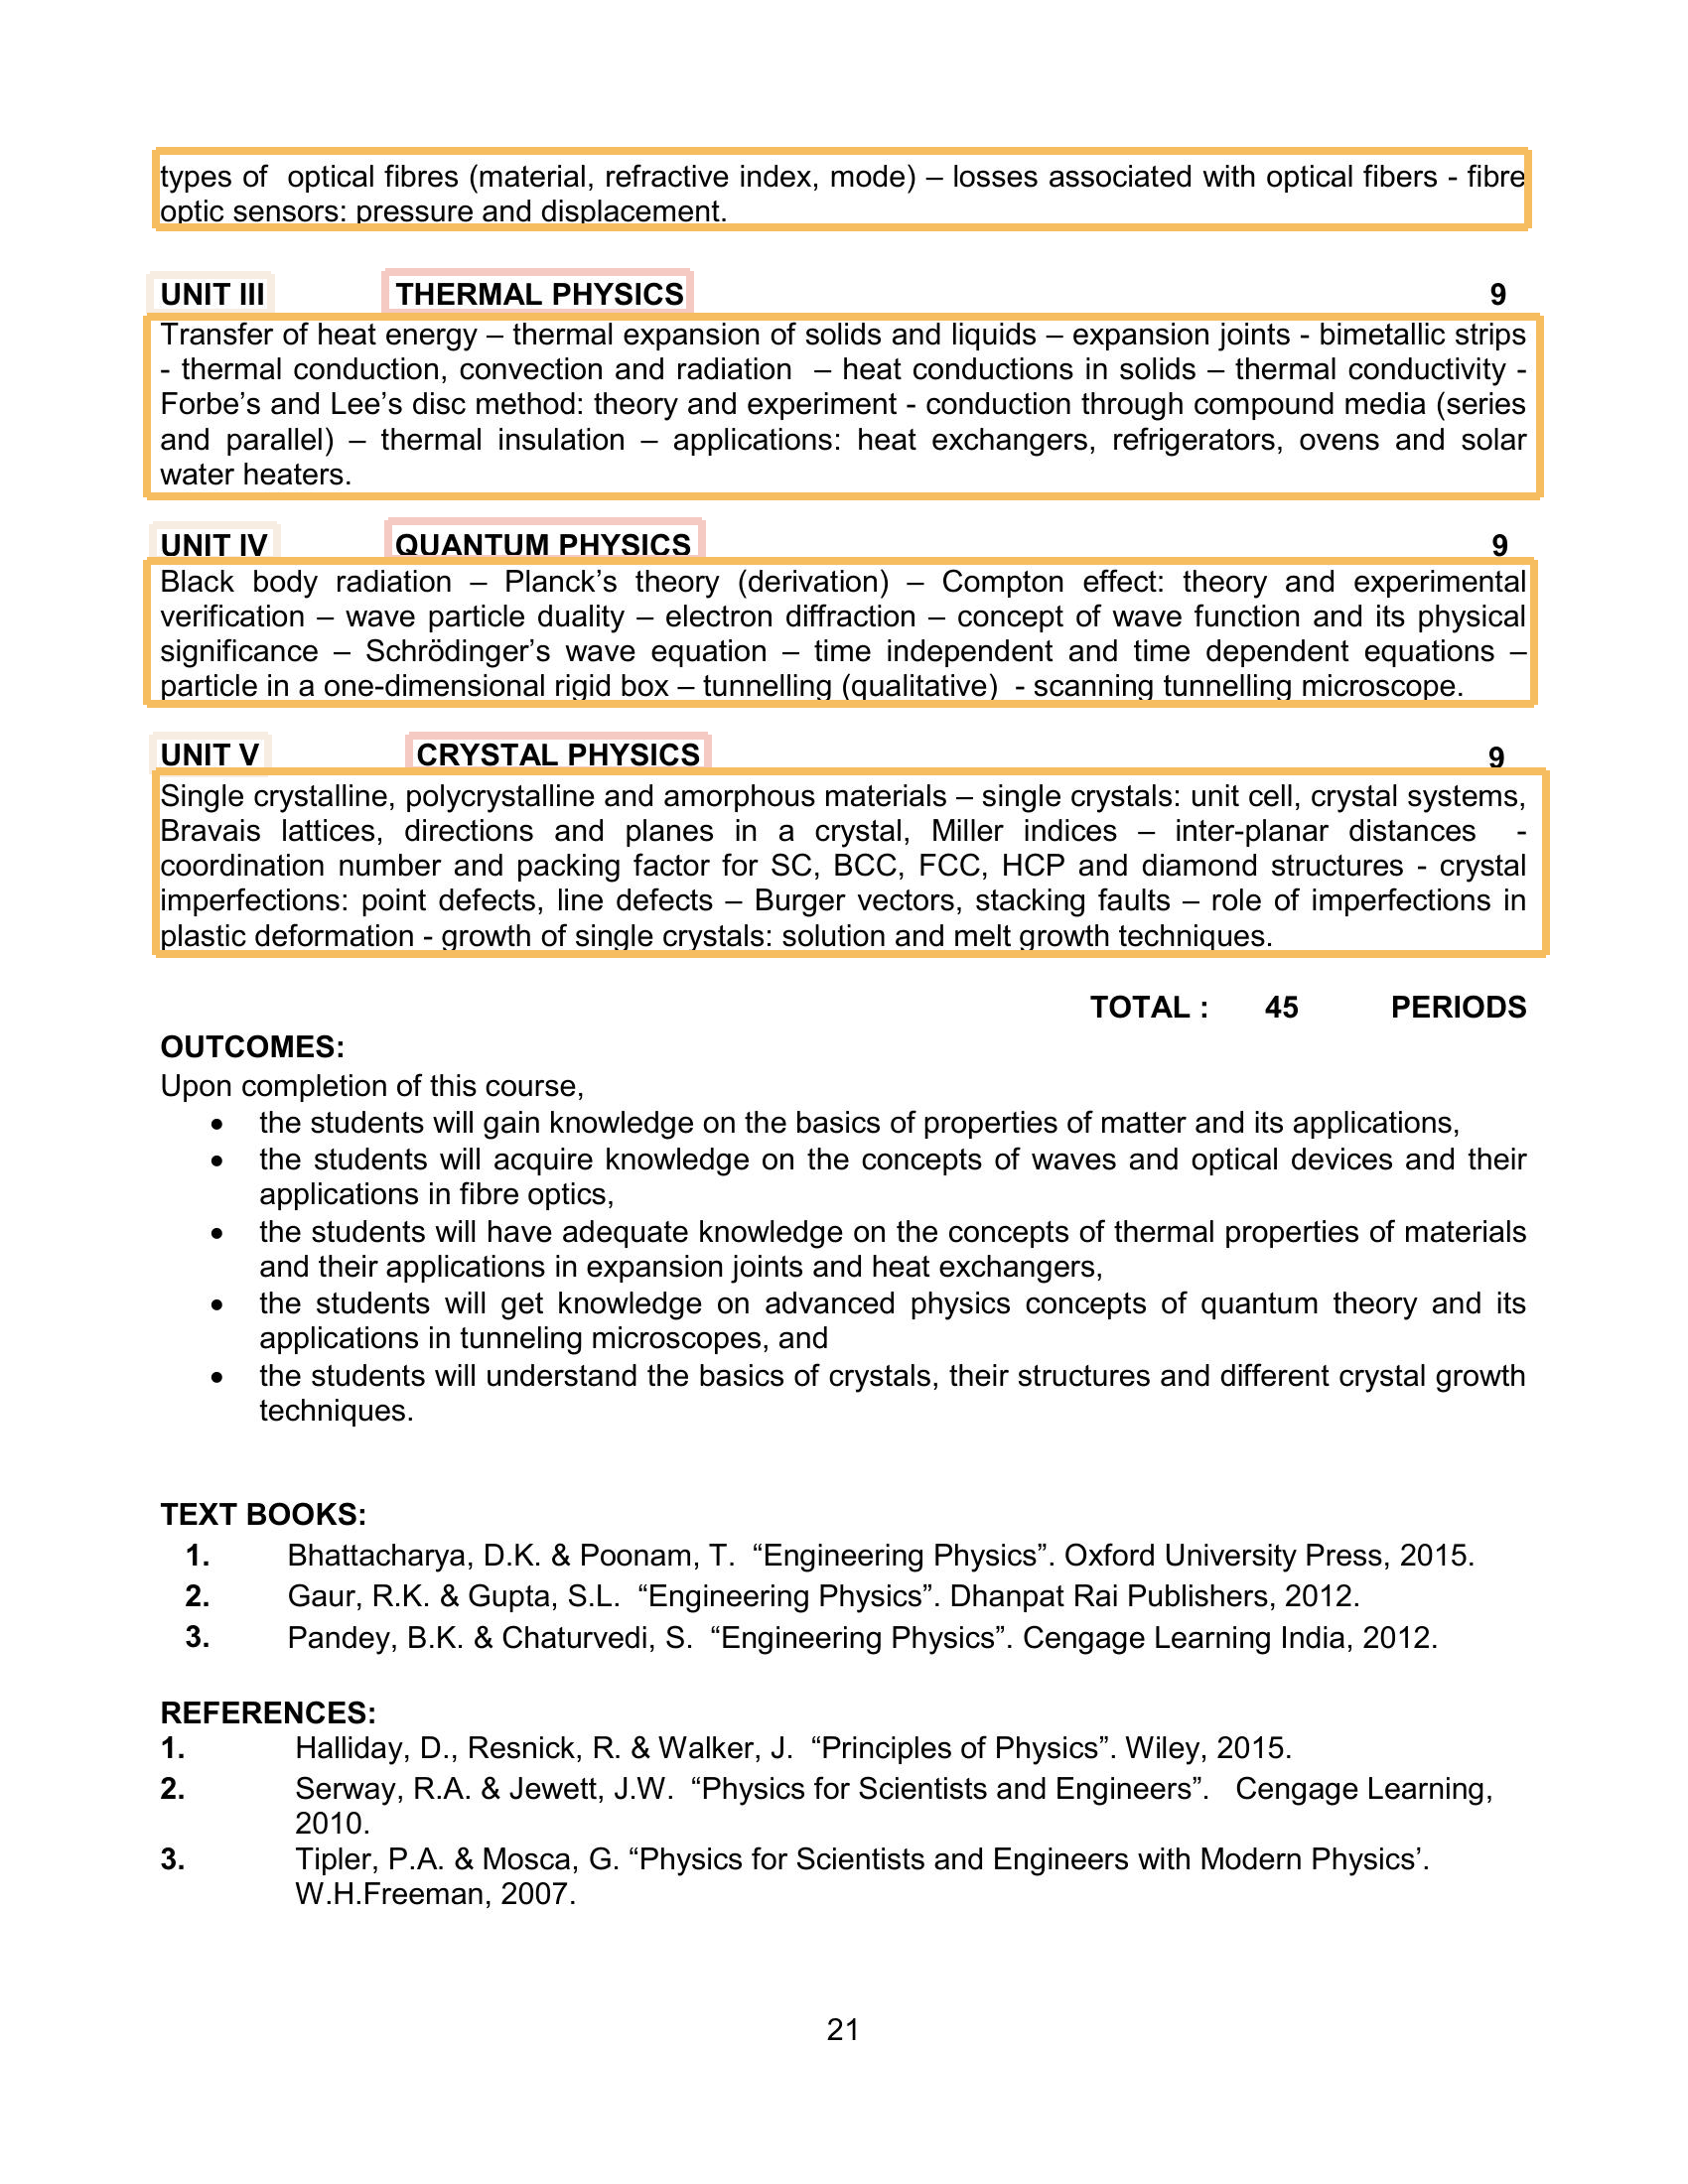

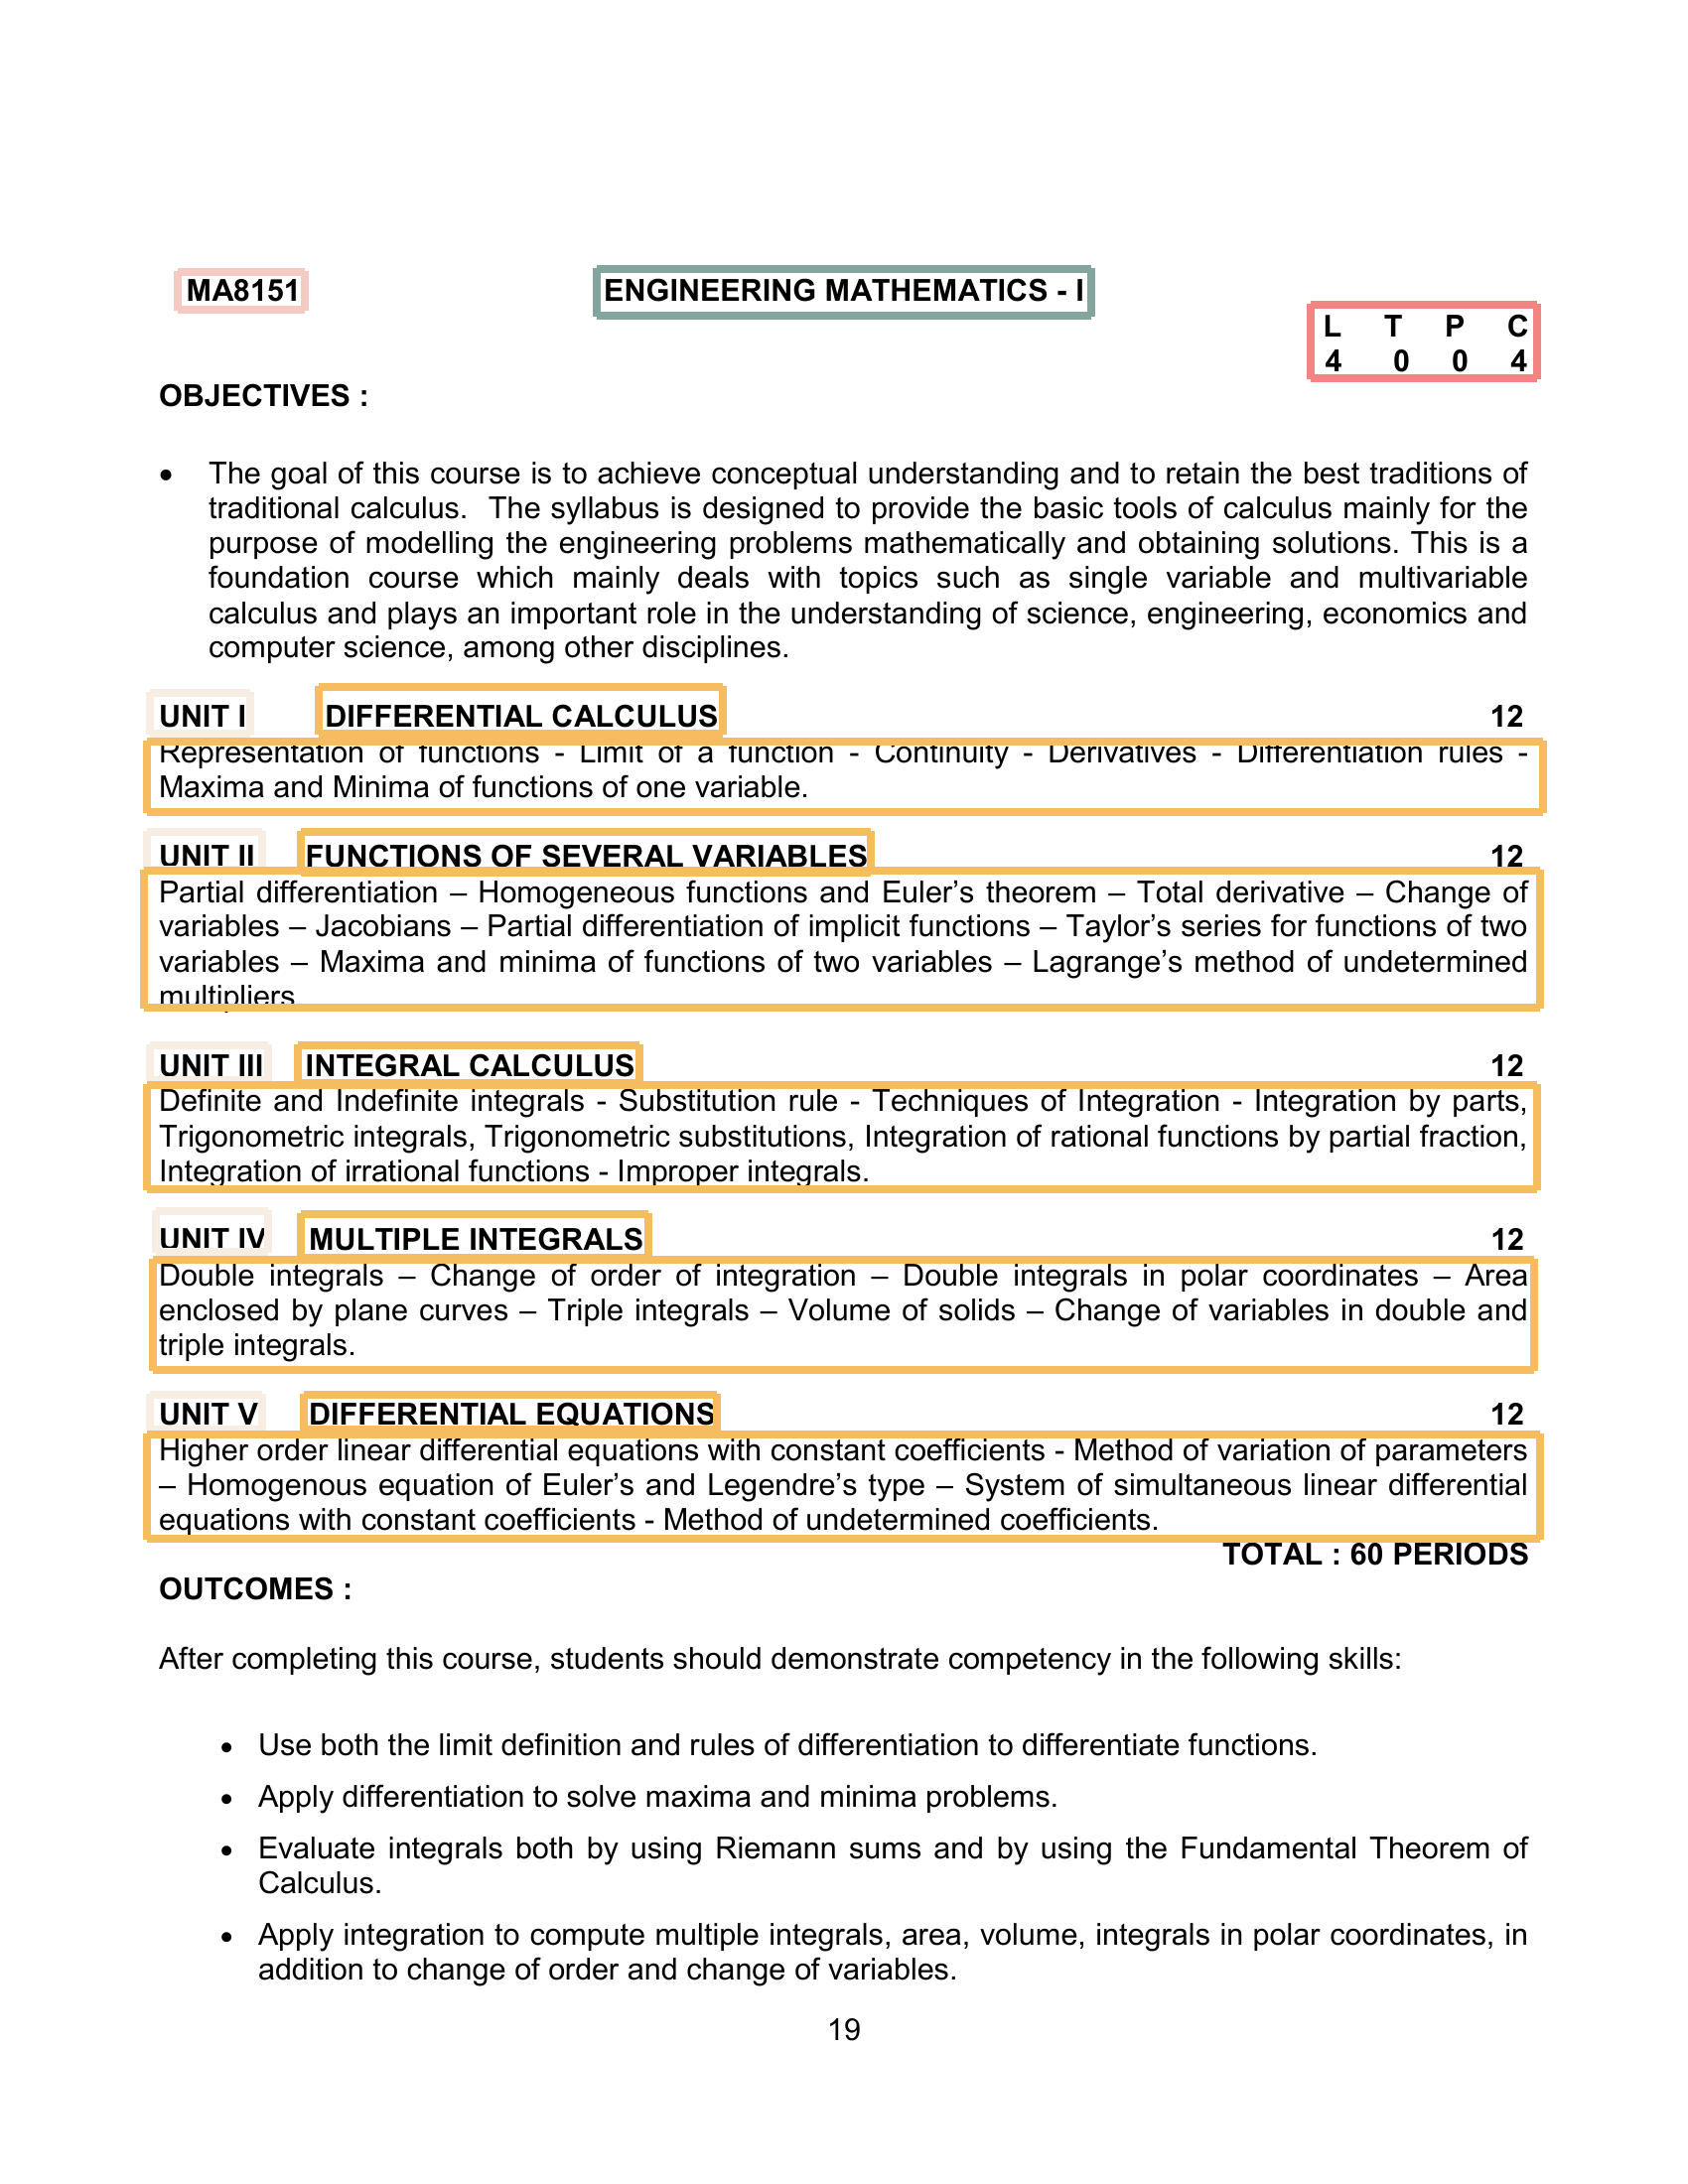

In [12]:
for image_id in random.sample(coco.imgs.keys(), 2):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))
    
    # print(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    # print(image_info)

    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    layout = load_coco_annotations(annotations, coco)

    viz = lp.draw_box(image[...,::-1], layout)
    display(viz) # show the results

In [13]:
# !pip install funcy

In [14]:
!python layout-model-training/utils/cocosplit.py --annotation-path data/annotations/result.json --split-ratio 0.85  --train data/annotations/train.json --test data/annotations/test.json

python: can't open file '/home/iamharish/lastpage-syllabus-parser/layout-model-training/utils/cocosplit.py': [Errno 2] No such file or directory


In [15]:
!python -c 'import torch; from torch.utils.cpp_extension import CUDA_HOME; print(torch.cuda.is_available(), CUDA_HOME)'

True /usr/local/cuda


In [19]:
# !cd /home/layout-model-training/scripts/
# !pwd
# !bash train_prima.sh

In [20]:
import requests
import layoutparser as lp

In [21]:
# r = requests.get("https://arxiv.org/pdf/2106.00676.pdf")
r = requests.get("https://cac.annauniv.edu/PhpProject1/aidetails/afug_2017_fu/01.%20B.E.EEE.pdf", verify=False)
with open("test.pdf", 'wb') as fp:
    fp.write(r.content)

/home/iamharish/lastpage-syllabus-parser/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cac.annauniv.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [22]:
pdf_tokens, pdf_images = lp.load_pdf("test.pdf", load_images=True)

In [23]:
model = lp.Detectron2LayoutModel(
    config_path = "./outputs/lastpage/fast_rcnn_R_50_FPN_3x/config.yaml",
    model_path = "./outputs/lastpage/fast_rcnn_R_50_FPN_3x/model_final.pth",
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # <-- Only output high accuracy preds
)

In [5]:
layout = model.detect(pdf_images[24])

/home/iamharish/lastpage-syllabus-parser/venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


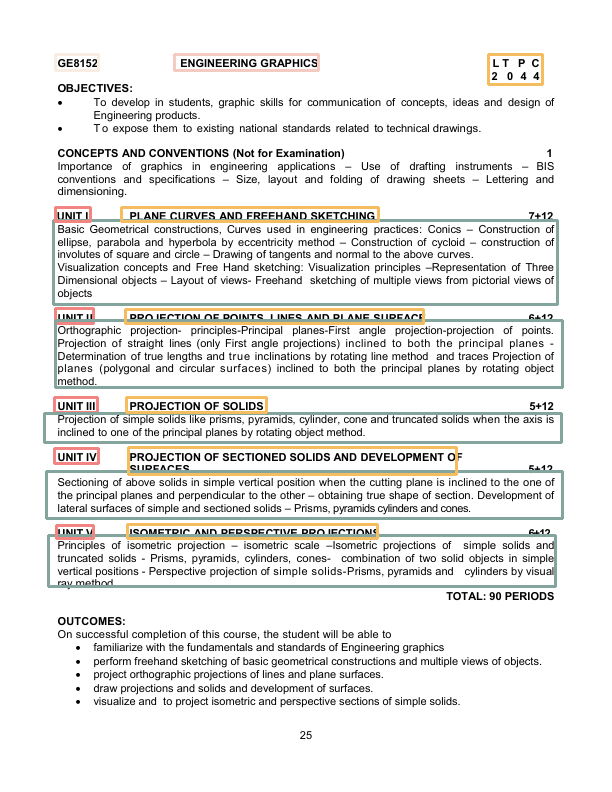

In [6]:
lp.draw_box(pdf_images[24], layout)

# END OF TRAINING - PLAYING AROUND WITH TRAINED MODEL

In [7]:
for page_index in [24, 25, 26]: #Reference Section 
    subjects = model.detect(pdf_images[page_index])
    break

In [17]:
for subject in subjects:
    subject_tokens = pdf_tokens[page_index].filter_by(subject, center=True)
    break

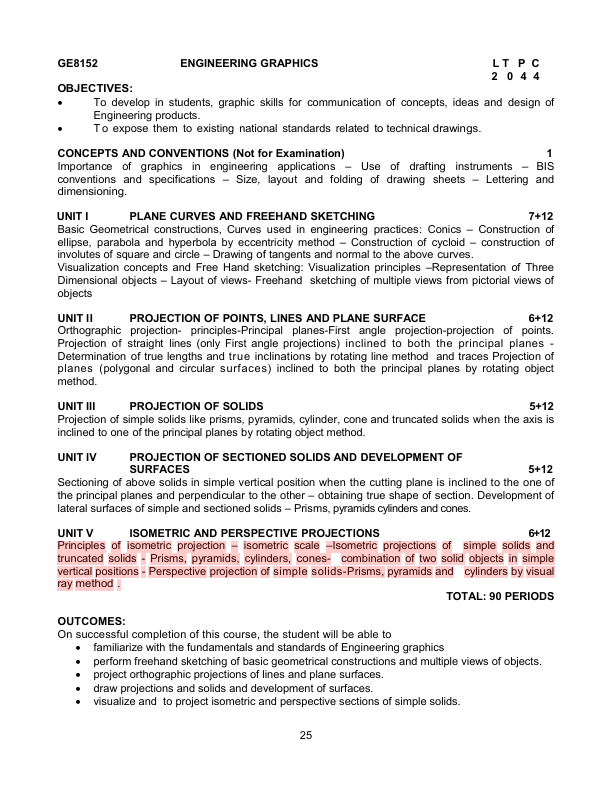

In [18]:
viz = lp.draw_box(pdf_images[page_index], subject_tokens, color_map={}, box_alpha=0.2, box_width=0)
viz

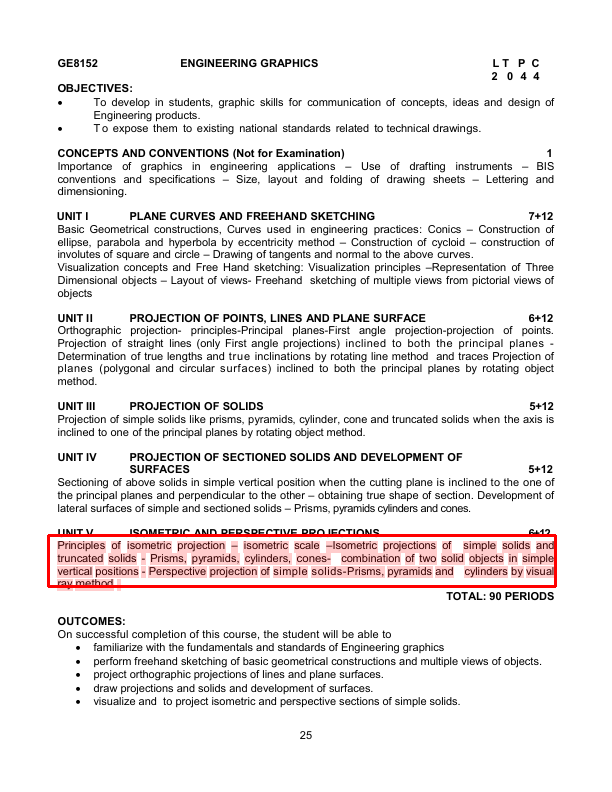

In [19]:
lp.draw_box(viz, [subject], color_map={}) # <- Overlay bib-item block tokens onto bib_tokens

In [20]:
" ".join(subject_tokens.get_texts())

'Principles of isometric projection – isometric scale –Isometric projections of s imple solids and truncated solids - Prisms, pyramids, cylinders, cones- combination of two solid objects in simple vertical positions - Perspective projection of simple solids-Prisms, pyramids and cylinders by visual ray method .'

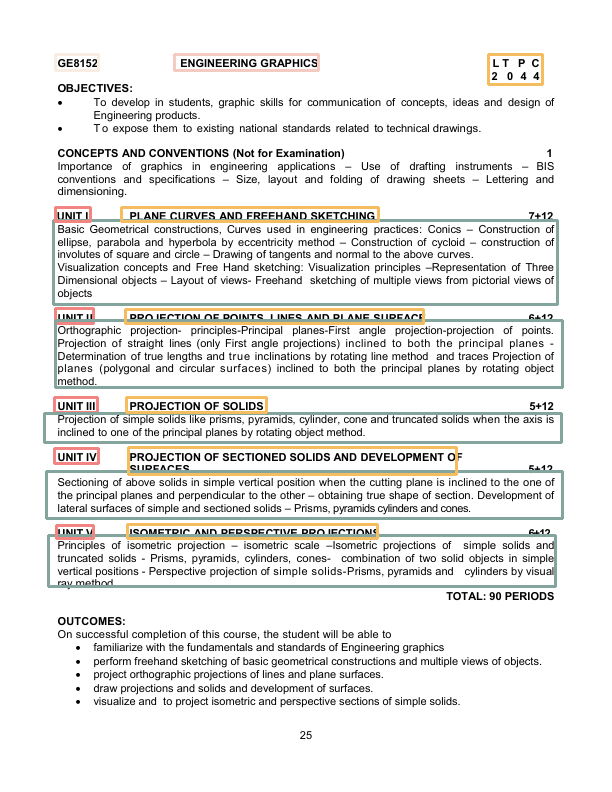

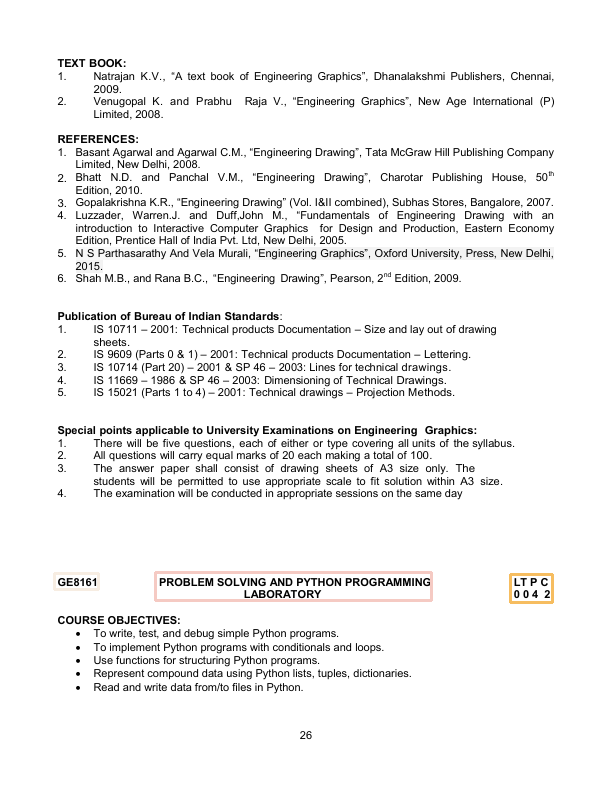

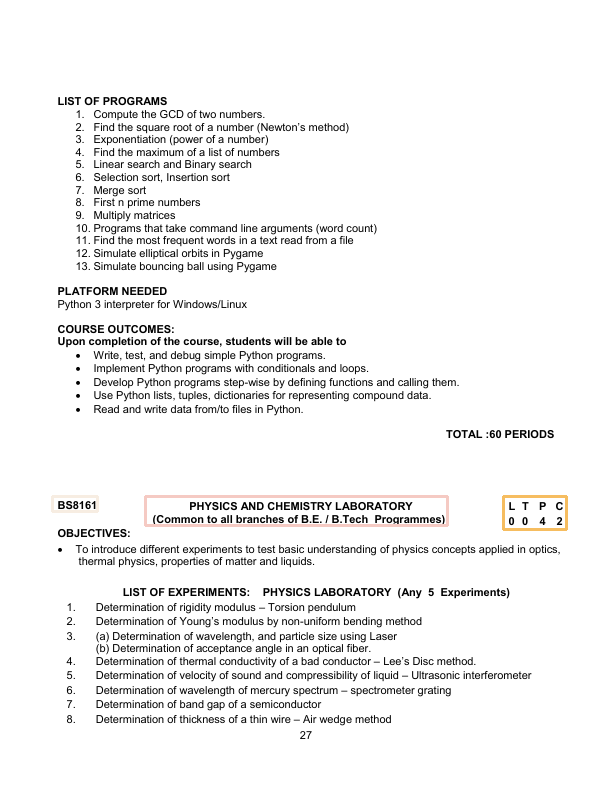

In [21]:
page_contents = {} 

for page_index in [22, 23, 24]: # Pages with Subject-Level Data 
    syllabus_items = model.detect(pdf_images[page_index])
    
    page_syllabus_tokens = []
    for syllabus_item in syllabus_items:
        syllabus_tokens = pdf_tokens[page_index].filter_by(syllabus_item, center=True)
        page_syllabus_tokens.append(syllabus_tokens)
        
    page_syllabus_tokens = sorted(page_syllabus_tokens, key=lambda tokens: min([ele.id for ele in tokens]))
    # Sort them using PDF Token Indices 
    
    page_contents[page_index] = [" ".join(syllabus_tokens.get_texts()) for syllabus_tokens in page_syllabus_tokens]



In [22]:
import pandas as pd 

(pd
 .DataFrame(tuple(pdf_bibs.items()), 
             columns=['page_index', 'bib-item'])
 .explode('bib-item')
 .reset_index(drop=True)
)

page_index                                           bib-item
0           24  Principles of isometric projection – isometric...
1           24                               ENGINEERING GRAPHICS
2           24                                            UNIT II
3           24  Basic Geometrical constructions, Curves used i...
4           24  Orthographic projection- principles-Principal ...
5           24                                             UNIT I
6           24                                           UNIT III
7           24  Projection of simple solids like prisms, pyram...
8           24              ISOMETRIC AND PERSPECTIVE PROJECTIONS
9           24                                             UNIT V
10          24  Sectioning of above solids in simple vertical ...
11          24                                    L T P C 2 0 4 4
12          24                PLANE CURVES AND FREEHAND SKETCHING
13          24  PROJECTION OF SECTIONED SOLIDS AND DEVELOPMENT...
14          24      PROJECTION OF POINTS, LINES AND PLANE SURFACE
15          24                                             GE8152
16          24                               PROJECTION OF SOLIDS
17          24                                            UNIT IV
18          25  PROBLEM SOLVING AND PYTHON PROGRAMMING LABORATORY
19          25                                     LT P C 0 0 4 2
20          25                                             GE8161
21          26                                    L T P C 0 0 4 2
22          26  PHYSICS AND CHEMISTRY LABORATORY (Common to al...
23          26                                             BS8161

In [33]:
pdf_bibs = {}

for page_index in [21, 22, 23]: #Reference Section 
    bib_items = model.detect(pdf_images[page_index])
    
    page_bib_tokens = []
    for bib_item in bib_items:
        bib_tokens = pdf_tokens[page_index].filter_by(bib_item, center=True)
        page_bib_tokens.append(bib_tokens)
        
    page_bib_tokens = sorted(page_bib_tokens, key=lambda tokens: min([ele.id for ele in tokens]))
    # Sort them using PDF Token Indices 
    
    pdf_bibs[page_index] = [" ".join(bib_tokens.get_texts()) for bib_tokens in page_bib_tokens]

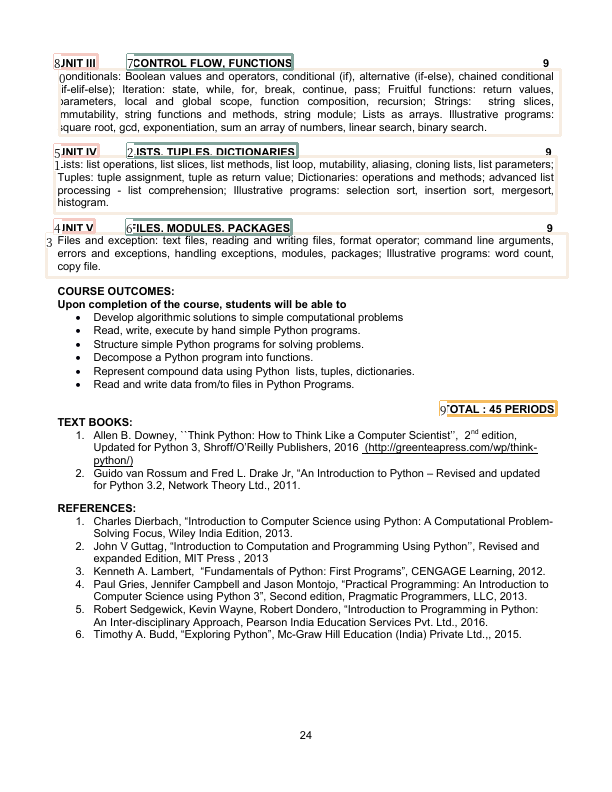

In [34]:
lp.draw_box(pdf_images[page_index], bib_items, show_element_id=True, id_font_size=12)

In [36]:
(pd
 .DataFrame(tuple(pdf_bibs.items()), 
             columns=['page_index', 'annotations'])
 .explode('annotations')
 .reset_index(drop=True)
)[:10]

page_index                                        annotations
0          21                                             CY8151
1          21                              ENGINEERING CHEMISTRY
2          21                                    L T P C 3 0 0 3
3          21                                             UNIT I
4          21                            WATER AND ITS TREATMENT
5          21  Hardness of water – types – expression of hard...
6          21                                            UNIT II
7          21                    SURFACE CHEMISTRY AND CATALYSIS
8          21  Adsorption: Types of adsorption – adsorption o...
9          21                                           UNIT III